# Proyek Sistem Rekomendasi Film:
- **Nama:** [Achmad Faiz Izzi]
- **Email:** [ahmadfaiz8365@gmail.com]
- **ID Dicoding:** [MC227D5Y1450]

# **Import Library**

In [ ]:
import os, shutil
# Manipulasi data
import pandas as pd
import numpy as np
# Visualisasi (opsional jika ingin eksplorasi data)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
# Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Testing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Insight:**

Beragam library digunakan untuk mendukung proses analisis data dan pengembangan model. Pandas dimanfaatkan untuk pengolahan data dalam format tabel, sedangkan NumPy digunakan dalam melakukan perhitungan numerik. Untuk keperluan visualisasi, digunakan Seaborn dan Matplotlib. TensorFlow berperan dalam membangun dan melatih model rekomendasi berbasis machine learning. Sementara itu, scikit-learn digunakan dalam proses ekstraksi fitur teks menggunakan TF-IDF, penerapan algoritma berbasis kedekatan data, serta membagi dataset menjadi data latih dan data validasi.

# **Data Understanding**

Pada tahap ini, dua file dataset yaitu `movies.csv` dan `ratings.csv` dimuat ke dalam DataFrame menggunakan library pandas. File `movies.csv` berisi informasi mengenai film seperti ID, judul, dan genre, sedangkan `ratings.csv` mencatat interaksi pengguna dengan film berupa rating yang diberikan. Setelah kedua file berhasil dimuat, keduanya digabungkan berdasarkan kolom movieId untuk membentuk satu DataFrame utama yang menyatukan data rating dengan informasi film terkait. Langkah ini penting agar setiap interaksi pengguna tidak hanya berisi angka penilaian, tetapi juga dilengkapi dengan konteks seperti judul dan genre film, sehingga dapat mendukung proses analisis serta pembangunan sistem rekomendasi yang lebih informatif dan akurat.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (4).json to kaggle (4).json


{'kaggle (4).json': b'{"username":"ahmadfaiz2012","key":"dee9402103db24d4d9f7e42d173d7426"}'}

In [ ]:
# Buat direktori jika belum ada
os.makedirs("/root/.kaggle", exist_ok=True)
# Pindahkan file ke direktori .kaggle
shutil.move("kaggle (4).json", "/root/.kaggle/kaggle.json")
# Atur permission agar tidak terlalu terbuka
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d parasharmanas/movie-recommendation-system
!unzip movie-recommendation-system.zip

Dataset URL: https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system
License(s): ODbL-1.0
 51% 84.0M/165M [00:00<00:00, 872MB/s]
100% 165M/165M [00:00<00:00, 652MB/s] 
Archive:  movie-recommendation-system.zip
  inflating: movies.csv              
  inflating: ratings.csv             


**Loading Dataset**

In [ ]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
df = pd.merge(movies, ratings, on='movieId')
df.drop(columns=['timestamp'], inplace=True)
df

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0
...,...,...,...,...,...
25000090,209157,We (2018),Drama,119571,1.5
25000091,209159,Window of the Soul (2001),Documentary,115835,3.0
25000092,209163,Bad Poems (2018),Comedy|Drama,6964,4.5
25000093,209169,A Girl Thing (2001),(no genres listed),119571,3.0


Output yang ditampilkan di atas merupakan isi dari dua dataset yang dugunakan dalam sistem rekomendasi ini

1. Dataset "Movies"
Berisi informasi dasar tentang film:
- movieId: ID unik untuk setiap film.
- title: Judul film beserta tahun rilis.
- genres: Genre film yang dipisahkan oleh tanda "|".

2. Dataset "Ratings"
Berisi data penilaian pengguna terhadap film:
- userId: ID pengguna yang memberikan rating.
- movieId: ID film yang diberi rating.
- rating: Skor atau penilaian film dari pengguna (biasanya dari 0.5 sampai 5).
- timestamp: Waktu penilaian dalam format UNIX timestamp.

# **Exploratory Data Analysis**

**Deskripsi Variabel**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   movieId  int64  
 1   title    object 
 2   genres   object 
 3   userId   int64  
 4   rating   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 953.7+ MB


Dataset gabungan **Movies** dan **Ratings** berisi 25.000.095 entri dengan lima kolom: `movieId` (ID film), `title` (judul film), `genres` (genre film), `userId` (ID User), dan `rating` (rating film). Semuanya lengkap tanpa data kosong, dan menggunakan memori sekitar 953.7 MB.

In [ ]:
df.describe()

,movieId,userId,rating
count,2.500010e+07,2.500010e+07,2.500010e+07
mean,2.138798e+04,8.118928e+04,3.533854e+00
std,3.919886e+04,4.679172e+04,1.060744e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,1.196000e+03,4.051000e+04,3.000000e+00
50%,2.947000e+03,8.091400e+04,3.500000e+00
75%,8.623000e+03,1.215570e+05,4.000000e+00
max,2.091710e+05,1.625410e+05,5.000000e+00


Statistik rating menunjukkan bahwa dari total 25 juta data, **rata-rata rating** film adalah **3.53** dengan **standar deviasi** sebesar **1.06**, yang menandakan variasi penilaian pengguna. Nilai rating minimum adalah **0.5** dan maksimum **5.0**. Sebagian besar rating berada di antara **3.0 (kuartil 1)** dan **4.0 (kuartil 3)**, dengan **nilai tengah (median)** di **3.5**, menunjukkan bahwa pengguna cenderung memberikan rating positif

In [ ]:
# Jumlah rating per film (top 10)
df_counts = df['movieId'].value_counts()
print("\nJumlah rating per film (top 10):")
print(df_counts.head(10))


Jumlah rating per film (top 10):
movieId
356     81491
318     81482
296     79672
593     74127
2571    72674
260     68717
480     64144
527     60411
110     59184
2959    58773
Name: count, dtype: int64


Data ini menunjukkan **10 film teratas dengan jumlah rating terbanyak**. Film dengan `movieId 356` menerima rating paling banyak, yaitu **81.491 rating**, diikuti oleh `movieId 318` dengan **81.482 rating**, dan seterusnya. Ini menunjukkan bahwa film-film tersebut sangat populer atau sering ditonton oleh pengguna dalam dataset.

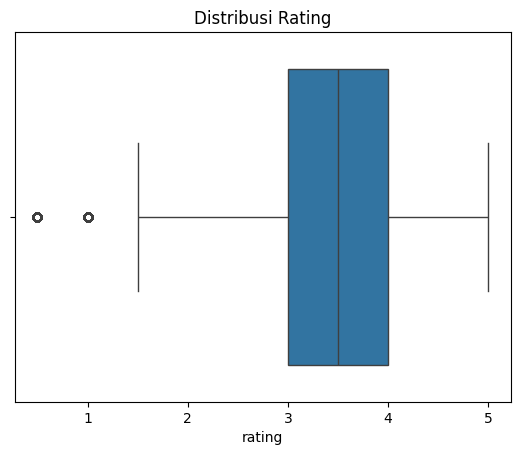

In [ ]:
# Visualisasi distribusi rating
sns.boxplot(x=df['rating'])
plt.title('Distribusi Rating')
plt.show()

Box plot menggambarkan bahwa sebagian besar rating berkisar antara 3 hingga 4, menunjukkan kecenderungan pengguna untuk memberikan penilaian positif terhadap film yang mereka saksikan.

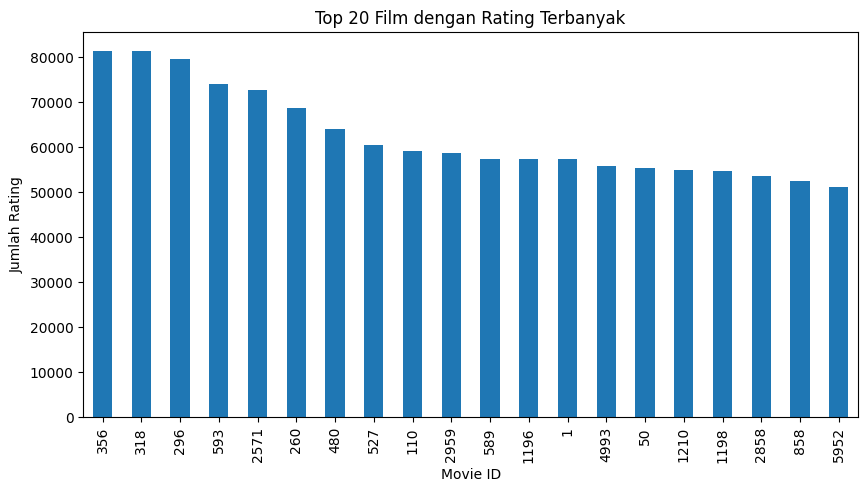

In [ ]:
rating_counts = df.groupby('movieId')['rating'].count().sort_values(ascending=False)
rating_counts.head(20).plot(kind='bar', figsize=(10,5))
plt.title('Top 20 Film dengan Rating Terbanyak')
plt.xlabel('Movie ID')
plt.ylabel('Jumlah Rating')
plt.show()

Grafik batang ini menampilkan 20 film yang menerima jumlah rating terbanyak dari pengguna. Informasi ini berguna untuk mengidentifikasi film-film populer yang berpotensi menjadi prioritas dalam sistem rekomendasi berbasis popularitas.

**Analisis Univariat**

In [ ]:
print('Banyak data id film : ', len(df.movieId.unique()))
print('Banyak data judul film : ', len(df.title.unique()))
print('Banyak data genre film : ', len(df.genres.unique()))
print('Banyak data id pengguna : ', len(df.userId.unique()))

Banyak data id film :  59047
Banyak data judul film :  58958
Banyak data genre film :  1621
Banyak data id pengguna :  162541


In [ ]:
print(df['rating'].value_counts().sort_index())

rating
0.5     393068
1.0     776815
1.5     399490
2.0    1640868
2.5    1262797
3.0    4896928
3.5    3177318
4.0    6639798
4.5    2200539
5.0    3612474
Name: count, dtype: int64


In [ ]:
genre_set = set()
for genre_string in movies['genres'].dropna():
    genres = genre_string.split('|')
    genre_set.update(genres)

In [ ]:
print("Jumlah genre unik:", len(genre_set))
print("Daftar genre unik:")
for genre in sorted(genre_set):
    print("-", genre)

Jumlah genre unik: 20
Daftar genre unik:
- (no genres listed)
- Action
- Adventure
- Animation
- Children
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- IMAX
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western


**Insight:**

Dataset ini mencakup 162.541 pengguna unik dan 59.047 film unik dengan total 58.958 judul film yang berbeda, menunjukkan adanya sejumlah kecil duplikasi atau variasi dalam penulisan judul. Nilai rating tersebar dari 0.5 hingga 5.0 dengan interval 0.5, mencerminkan sistem penilaian berbasis bintang setengah. Genre film mencakup 20 kategori unik, mulai dari aksi, drama, hingga film noir dan dokumenter, serta termasuk label "(no genres listed)" yang menunjukkan adanya data tidak lengkap.



# **Data Preparation**

In [ ]:
# Mendeteksi dan menangani missing values
df.isna().sum()

,0
movieId,0
title,0
genres,0
userId,0
rating,0


Output menunjukkan bahwa tidak ada missing value pada dataset, sehingga data dinyatakan lengkap dan siap diproses lebih lanjut tanpa perlu penanganan khusus seperti pembersihan data.

In [ ]:
# Mendeteksi dan menangani data duplikat
print(df.duplicated().sum())

0


Output menunjukkan bahwa tidak ada data duplikat pada dataset, sehingga data dinyatakan lengkap dan siap diproses lebih lanjut

**Mensample dataset**

Tahap ini dilakukan untuk mengurangi ukuran dataset menjadi subset yang lebih kecil (500.000 baris) agar proses eksplorasi data, pelatihan model, dan evaluasi dapat dilakukan dengan lebih cepat dan efisien Penggunaan `random_state=42` memastikan bahwa proses sampling bersifat reproducible, sehingga hasil eksperimen tetap konsisten setiap kali kode dijalankan.

In [ ]:
df_sample = df.sample(500000, random_state=42).copy()

**Preprocesssing Content-Based Filtering**

Tahap preprocessing untuk Content-Based Filtering diperlukan agar fitur teks seperti genre dapat diubah menjadi format numerik yang bisa diproses oleh algoritma, salah satunya menggunakan TF-IDF (Term Frequency-Inverse Document Frequency).

In [ ]:
# Mengubah genre film menjadi representasi vektor TF-IDF
movie_features = df_sample.drop_duplicates('movieId')[['movieId', 'title', 'genres']].reset_index(drop=True)

tfidf = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_matrix = tfidf.fit_transform(movie_features['genres'])

cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cbf_df = df_sample.copy()

**Preprocesssing Content-Based Filtering**

Preprocessing untuk Collaborative Filtering bertujuan untuk menyiapkan data rating agar sesuai dengan format yang dibutuhkan oleh library Surprise, sehingga proses pemodelan dapat berjalan dengan lancar dan akurat.

In [ ]:
user_ids = cbf_df['userId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

movie_ids = cbf_df['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

cbf_df['user'] = cbf_df['userId'].map(user_to_user_encoded)
cbf_df['movie'] = cbf_df['movieId'].map(movie_to_movie_encoded)

In [ ]:
num_users = len(user_to_user_encoded)
num_movies = len(movie_encoded_to_movie)
min_rating = cbf_df['rating'].min()
max_rating = cbf_df['rating'].max()

print(f'Users: {num_users}, Movies: {num_movies}, Rating range: {min_rating}–{max_rating}')

Users: 118241, Movies: 18214, Rating range: 0.5–5.0


Output tersebut menandakan bahwa data rating sudah berada dalam rentang valid (0.5 sampai 5.0), terdapat 118.241 pengguna, dan terdapat 18.214 film.

**Splitting Data**

In [ ]:
# Membagi Data untuk Training dan Validasi
x = cbf_df[['user', 'movie']].values
y = cbf_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

Membagi data rating menjadi data latih dan data validasi dengan rasio 80:20 dan menggunakan random_state untuk memastikan pembagian data yang konsisten.

# **Model Development dengan Content-Based Filtering**

In [ ]:
def rekomendasi_dengan_genre(genre_input, top_n=5):
    genre_mask = movie_features['genres'].str.contains(genre_input, case=False, na=False)
    matching_movies = movie_features[genre_mask]

    if matching_movies.empty:
        print(f"Tidak ada film pada genre '{genre_input}' ditemukan.")
        return

    idx = matching_movies.index[0]
    sim_scores = list(enumerate(cos_sim[idx]))

    sim_scores = [x for x in sim_scores if x[0] != idx]

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_n]

    print(f"Rekomendasi film mirip berdasarkan genre '{genre_input}' dengan referensi:")
    print(f"> {movie_features.iloc[idx]['title']} | Genre: {movie_features.iloc[idx]['genres']}")

    for i, (movie_idx, _) in enumerate(sim_scores, 1):
        title = movie_features.iloc[movie_idx]['title']
        genres = movie_features.iloc[movie_idx]['genres']
        print(f"{i}. {title} | Genre: {genres}")

In [ ]:
# Uji coba rekomendasi film dengan input Genre
rekomendasi_dengan_genre("Drama")

Rekomendasi film mirip berdasarkan genre 'Drama' dengan referensi:
> Three Days of the Condor (3 Days of the Condor) (1975) | Genre: Drama|Mystery|Romance|Thriller
1. Blindness (2008) | Genre: Drama|Mystery|Romance|Thriller
2. Conspiracy Theory (1997) | Genre: Drama|Mystery|Romance|Thriller
3. Vertigo (1958) | Genre: Drama|Mystery|Romance|Thriller
4. Rebecca (1940) | Genre: Drama|Mystery|Romance|Thriller
5. Boxing Helena (1993) | Genre: Drama|Mystery|Romance|Thriller


In [ ]:
def rekomendasi_film_content(title, top_n=5):
    match = movie_features[movie_features['title'].str.lower() == title.lower()]
    if match.empty:
        print("Judul film tidak ditemukan.")
        return

    idx = match.index[0]
    sim_scores = list(enumerate(cos_sim[idx]))

    sim_scores = [x for x in sim_scores if x[0] != idx]

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_n]

    print(f"Rekomendasi untuk: {movie_features.iloc[idx]['title']} | Genre: {movie_features.iloc[idx]['genres']}")
    for i, (movie_idx, _) in enumerate(sim_scores, 1):
        rec_title = movie_features.iloc[movie_idx]['title']
        rec_genre = movie_features.iloc[movie_idx]['genres']
        print(f"{i}. {rec_title} | Genre: {rec_genre}")

In [ ]:
# Uji coba rekomendasi film dengan input Judul
rekomendasi_film_content("Waiting to Exhale (1995)")

Rekomendasi untuk: Waiting to Exhale (1995) | Genre: Comedy|Drama|Romance
1. Terminal, The (2004) | Genre: Comedy|Drama|Romance
2. Graduate, The (1967) | Genre: Comedy|Drama|Romance
3. About Last Night... (1986) | Genre: Comedy|Drama|Romance
4. Singles (1992) | Genre: Comedy|Drama|Romance
5. Sleepless in Seattle (1993) | Genre: Comedy|Drama|Romance


**Insight:**

Model Content-Based Filtering yang dikembangkan memberikan rekomendasi film berdasarkan kemiripan konten, khususnya dari informasi genre. Dengan memanfaatkan teknik TF-IDF untuk mengekstraksi fitur dari kolom genre dan menghitung kemiripan antar film menggunakan cosine similarity, sistem mampu menyarankan film yang memiliki karakteristik serupa dengan film tertentu atau genre yang dipilih pengguna. Pendekatan ini tidak memerlukan data historis dari pengguna, sehingga efektif untuk mengatasi permasalahan cold-start pada pengguna baru. Rekomendasi yang dihasilkan bersifat personal dan dapat dijelaskan secara transparan, karena didasarkan pada kesamaan fitur konten film.


# **Model Development dengan Collaborative Filtering**

In [ ]:
def rekomendasi_film_dari_user(user_id, model, cbf_df, user_to_user_encoded, user_encoded_to_user,
                              movie_to_movie_encoded, movie_encoded_to_movie, top_k=10):

    if user_id not in user_to_user_encoded:
        print(f"User {user_id} tidak ditemukan di data training.")
        return []

    user_encoded = user_to_user_encoded[user_id]

    movies_watched = cbf_df[cbf_df['userId'] == user_id]['movieId'].unique()
    movies_not_watched = [m for m in movie_to_movie_encoded.keys() if m not in movies_watched]
    movies_not_watched_encoded = [movie_to_movie_encoded[m] for m in movies_not_watched]

    user_array = np.array([user_encoded] * len(movies_not_watched_encoded))
    movie_array = np.array(movies_not_watched_encoded)
    input_array = np.vstack((user_array, movie_array)).T

    pred_ratings = model.predict(input_array, verbose=0).flatten()

    top_indices = pred_ratings.argsort()[-top_k:][::-1]
    top_movie_encoded = [movies_not_watched_encoded[i] for i in top_indices]
    top_movie_ids = [movie_encoded_to_movie[m] for m in top_movie_encoded]

    print(f"\nRekomendasi {top_k} film untuk user {user_id}:")

    for movie_id in top_movie_ids:
        title = cbf_df[cbf_df['movieId'] == movie_id]['title'].values
        if len(title) > 0:
            print(f"- {title[0]}")
        else:
            print(f"- Movie ID {movie_id} (judul tidak ditemukan)")

    return top_movie_ids

**Insight:**

Model Collaborative Filtering yang digunakan bertujuan memberikan rekomendasi film yang dipersonalisasi berdasarkan pola interaksi pengguna. Dengan memanfaatkan model neural network yang telah dilatih, sistem ini memprediksi seberapa besar kemungkinan seorang pengguna akan menyukai film yang belum pernah ditonton, berdasarkan pola rating yang diberikan sebelumnya. Setiap pengguna dan film direpresentasikan dalam bentuk vektor embedding, dan prediksi rating dihitung dari kombinasi vektor tersebut. Model ini efektif dalam menangkap preferensi tersembunyi pengguna dan memberikan rekomendasi yang relevan, terutama ketika riwayat interaksi cukup tersedia. Namun, pendekatan ini bergantung pada data historis dan kurang efektif untuk pengguna baru yang belum memiliki interaksi (cold-start problem).


**Proses Training**

In [ ]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

In [ ]:
model = RecommenderNet(num_users, num_movies, embedding_size=50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x_train, y_train,
    batch_size=256,
    epochs=3,
    validation_data=(x_val, y_val)
)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 169s 106ms/step - loss: 0.6633 - root_mean_squared_error: 0.2660 - val_loss: 0.6214 - val_root_mean_squared_error: 0.2231
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 186s 96ms/step - loss: 0.6352 - root_mean_squared_error: 0.2319 - val_loss: 0.6573 - val_root_mean_squared_error: 0.2540
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 206s 99ms/step - loss: 0.6587 - root_mean_squared_error: 0.2503 - val_loss: 0.6597 - val_root_mean_squared_error: 0.2502


In [ ]:
# Uji coba pemberian rekomendasi
user_sample = cbf_df['userId'].sample(1).iloc[0]
rekomendasi_film_dari_user(
    user_sample,
    model,
    cbf_df,
    user_to_user_encoded,
    user_encoded_to_user,
    movie_to_movie_encoded,
    movie_encoded_to_movie,
    top_k=10
)


Rekomendasi 10 film untuk user 33048:
- Schindler's List (1993)
- Silence of the Lambs, The (1991)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
- Princess Mononoke (Mononoke-hime) (1997)
- Godfather, The (1972)
- Pulp Fiction (1994)
- Wallace & Gromit: The Wrong Trousers (1993)
- 12 Angry Men (1957)
- Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
- Star Wars: Episode IV - A New Hope (1977)


[527, 593, 750, 3000, 858, 296, 1148, 1203, 32, 260]

**Insight:**

Proses training pada model Collaborative Filtering ini dilakukan dengan pendekatan neural network menggunakan arsitektur embedding untuk memetakan pengguna dan film ke dalam ruang representasi laten. Model dilatih dengan pasangan data pengguna dan film (`x_train`) serta nilai rating yang telah dinormalisasi (`y_train`). Selama pelatihan, model mempelajari hubungan antara pengguna dan film melalui dot product embedding, ditambah bias, lalu diaktifkan dengan fungsi sigmoid. Proses optimisasi dilakukan menggunakan algoritma Adam dengan learning rate 0.001, dan kinerjanya dievaluasi menggunakan metrik Root Mean Squared Error (RMSE). Selama tiga epoch pelatihan, model juga divalidasi menggunakan data terpisah untuk memastikan performa yang stabil dan menghindari overfitting. Insight utama dari proses ini adalah bahwa model dapat secara bertahap menyesuaikan bobotnya untuk memprediksi preferensi pengguna secara akurat berdasarkan pola historis.


# **Evaluation**

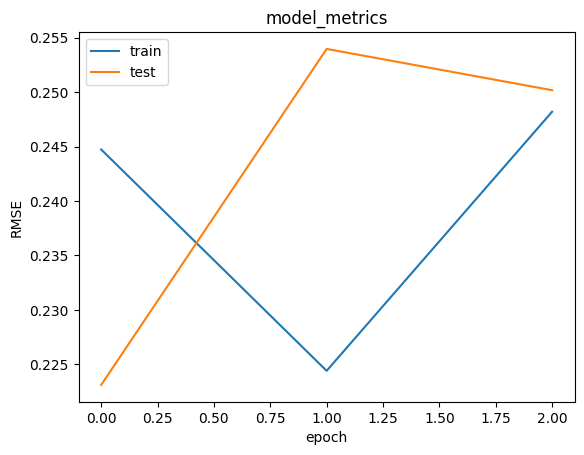

In [ ]:
# Visualisasi Metrix
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Plot di atas menunjukkan nilai Root Mean Squared Error (RMSE) pada data training dan testing selama proses training model selama 3 epoch.

- Epoch 0–1: RMSE pada training menurun (model membaik), tapi RMSE pada testing meningkat — ini bisa menjadi tanda awal overfitting.
- Epoch 1–2: RMSE pada training meningkat kembali, dan RMSE pada testing sedikit menurun, namun masih lebih tinggi dari awal.

**Evaluasi dengan RMSE**

In [ ]:
train_rmse_last = history.history['root_mean_squared_error'][-1]
val_rmse_last = history.history['val_root_mean_squared_error'][-1]
print(f"Final RMSE - Train: {train_rmse_last:.4f}, Validation: {val_rmse_last:.4f}")

Final RMSE - Train: 0.2482, Validation: 0.2502


Model menghasilkan nilai RMSE sebesar 0.2482 pada data pelatihan dan 0.2502 pada data validasi. Hasil ini menunjukkan model mampu memprediksi dengan akurat dan tidak menunjukkan tanda-tanda overfitting.